In [1]:
%load_ext autoreload
%autoreload 1

In [3]:
import pandas as pd
import numpy as np

import sys 
sys.path.append("../..") 
import os
%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from collections import defaultdict

from utils import prinT

import seaborn as sns
from matplotlib import pyplot as plt

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

In [4]:
model = p2v.P2V()
d=100
w=10

2024-08-18 14:31:51 -- start loading Mag_venue_info_df
2024-08-18 14:31:51 -- finish.
2024-08-18 14:31:51 -- start loading labeled_journal_info_df
2024-08-18 14:31:51 -- finish.


## tracking PRL&JACS

Journal of the American Chemical Society  
111155417  
Physical Review Letters  
24807848  

## JACS

In [5]:
def default_value():
    return 0


def count_paper_num_for_subarea(VID, percentage: bool=False, collapse_into_others: int=20):
    dict_list = []
    for i in range(len(model.start_year_list)-5, len(model.start_year_list)):
        start_year=model.start_year_list[i]
        end_year=model.end_year_list[i]
        prinT("start searching in %s to %s" %(start_year, end_year))

        model.load_paper_df(full_load=False, start_year=start_year, end_year=end_year)
        model.load_ref_df(full_load=False, start_year=start_year, end_year=end_year)
        VID_labeled = model.load_VID_labeled(start_year, end_year, d, w)
        VID_labeled_df = pd.DataFrame(VID_labeled)
        VID_labeled_df.set_index('VID', inplace=True)

        journal_df = model.target_paper_df[model.target_paper_df.VenueID == VID]
        journal_ref_df = pd.merge(journal_df, model.target_ref_df, left_on='PaperID', right_on='PaperID')
        journal_ref_df = pd.merge(journal_ref_df, model.target_paper_df, left_on='PaperReferenceID', right_on='PaperID')
        journal_ref_df.drop(columns=['PaperReferenceID'], inplace=True)
        journal_ref_df = pd.merge(journal_ref_df, VID_labeled_df, left_on='VenueID_y', right_index=True)

        journal_ref_df.drop(journal_ref_df[
                            (journal_ref_df['subarea_label'].str.contains('General'))|
                            (journal_ref_df['subarea_label'].str.contains('miscellaneous'))|
                            (journal_ref_df['subarea_label']=='Multidisciplinary')].index, 
                            inplace=True)

        subarea_paper_count = defaultdict(default_value)
        for row in journal_ref_df.groupby(['PaperID_x'])['subarea_label'].agg(pd.Series.mode):
            if type(row) == str:
                subarea_paper_count[row] = subarea_paper_count[row] + 1
            if type(row) == np.ndarray:
                subarea_num = len(row)
                for subarea in row:
                    subarea_paper_count[subarea] = subarea_paper_count[subarea] + 1/subarea_num
        dict_list.append(dict(subarea_paper_count))
    count_df = pd.DataFrame(dict_list).T
    count_df.columns = ['1970s', '1980s', '1990s', '2000s', '2010s']
    count_df['sum']=count_df.sum(axis=1)

    if collapse_into_others != 0:
        count_df.reset_index(inplace=True)
        count_df = count_df.sort_values("sum", ascending=False)
        count_df_up = count_df.iloc[:collapse_into_others]
        count_df_full = pd.concat([count_df_up, pd.DataFrame({'index': 'others', 
                                                            '1970s': count_df['1970s'].iloc[10:].sum(), 
                                                            '1980s': count_df['1980s'].iloc[10:].sum(), 
                                                            '1990s': count_df['1990s'].iloc[10:].sum(), 
                                                            '2000s': count_df['2000s'].iloc[10:].sum(), 
                                                            '2010s': count_df['2010s'].iloc[10:].sum(), 
                                                            'sum': count_df['sum'].iloc[7:].sum()}, 
                                                            index=[0])], 
                                ignore_index=True)
        count_df_full.set_index('index', inplace=True)
    else:
        count_df_full = count_df


    if percentage:
        count_df_full['1970s'] = (count_df_full['1970s']/count_df_full['1970s'].sum()) * 100
        count_df_full['1980s'] = (count_df_full['1980s']/count_df_full['1980s'].sum()) * 100
        count_df_full['1990s'] = (count_df_full['1990s']/count_df_full['1990s'].sum()) * 100
        count_df_full['2000s'] = (count_df_full['2000s']/count_df_full['2000s'].sum()) * 100
        count_df_full['2010s'] = (count_df_full['2010s']/count_df_full['2010s'].sum()) * 100

    count_df_full.index.rename('decade', inplace=True)
    count_df_full.drop('sum', axis=1, inplace=True)

    return count_df_full.T


def cal_subarea_avg_cs(target_VID: int):
    cs_data = []
    for i in range(len(model.start_year_list)-5, len(model.start_year_list)):
        model.load_wv(model.start_year_list[i], model.end_year_list[i], d, w)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)
        full_vector_list = model.wv.get_normed_vectors()

        VID_labeled = model.load_VID_labeled(model.start_year_list[i], model.end_year_list[i], d, w)
        label_list = VID_labeled['subarea_label']
        labeled_VID_list = VID_labeled['VID']
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in labeled_VID_list])

        single_decade_data = {}
        subareas = list(set(label_list))
        for subarea in subareas:
            single_subarea_idx_list = [idx for idx, label in list(enumerate(label_list)) if label == subarea]
            single_subarea_cs = cosine_similarity(target_journal_vector.reshape(1, -1), labeled_vector_list[single_subarea_idx_list])
            general_cs = cosine_similarity(target_journal_vector.reshape(1, -1), full_vector_list)
            
            single_decade_data[subarea] = np.mean((single_subarea_cs))/np.mean(general_cs)
        cs_data.append(single_decade_data)
    cs_df = pd.DataFrame(cs_data).T
    cs_df.columns = ['1970s', '1980s', '1990s', '2000s', '2010s']
    cs_df['sum']=cs_df.sum(axis=1)
    cs_df = cs_df.sort_values("sum", ascending=False)
    cs_df.index.rename('decade', inplace=True)
    cs_df.drop('sum', axis=1, inplace=True)

    return cs_df.T

In [6]:
count_df = count_paper_num_for_subarea(111155417, collapse_into_others=20)

2024-08-18 14:32:51 -- start searching in 1970 to 1979
2024-08-18 14:32:51 -- start loading 'paper_df'...
2024-08-18 14:32:52 -- finish.
2024-08-18 14:32:52 -- start loading 'ref_df'...
2024-08-18 14:32:53 -- finish.
2024-08-18 14:32:53 -- start loading VID_labeled...
2024-08-18 14:32:53 -- finish.
2024-08-18 14:32:55 -- start searching in 1980 to 1989
2024-08-18 14:32:55 -- start loading 'paper_df'...
2024-08-18 14:32:55 -- finish.
2024-08-18 14:32:55 -- start loading 'ref_df'...
2024-08-18 14:32:57 -- finish.
2024-08-18 14:32:57 -- start loading VID_labeled...
2024-08-18 14:32:57 -- finish.
2024-08-18 14:33:00 -- start searching in 1990 to 1999
2024-08-18 14:33:00 -- start loading 'paper_df'...
2024-08-18 14:33:02 -- finish.
2024-08-18 14:33:02 -- start loading 'ref_df'...
2024-08-18 14:33:05 -- finish.
2024-08-18 14:33:05 -- start loading VID_labeled...
2024-08-18 14:33:05 -- finish.
2024-08-18 14:33:10 -- start searching in 2000 to 2009
2024-08-18 14:33:10 -- start loading 'paper_d

In [7]:
count_df

decade,Organic Chemistry,Physical and Theoretical Chemistry,Inorganic Chemistry,Biochemistry,Polymers and Plastics,Condensed Matter Physics,Molecular Biology,Catalysis,Cell Biology,Analytical Chemistry,"Renewable Energy, Sustainability and the Environment",Drug Discovery,"Electronic, Optical and Magnetic Materials",Biophysics,Genetics,Pharmaceutical Science,Electrochemistry,Biotechnology,Spectroscopy,"Atomic and Molecular Physics, and Optics",others
1970s,4.000000,4.000000,4.500000,1.000000,NaN,2.500000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
1980s,6.500000,4.000000,6.500000,2.000000,1.000000,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,3.000000
1990s,1940.350000,1749.909524,1418.716667,1226.576190,236.742857,254.192857,241.350000,52.783333,92.600000,113.392857,0.333333,89.883333,4.650000,32.583333,56.683333,10.866667,28.400000,17.083333,85.116667,16.166667,800.385714
2000s,5114.372619,5022.121429,3281.959524,2772.983333,1032.978571,1280.541667,808.157143,330.476190,535.771429,450.305952,24.642857,375.844048,72.866667,429.260714,225.495238,203.410714,140.286905,297.132143,150.884524,47.409524,3182.332143
2010s,7254.749242,5772.702020,3080.243290,2136.507215,1498.334560,920.452814,784.119481,1098.454762,487.732576,544.689286,984.709524,268.297619,537.645635,123.774603,245.381349,309.114286,247.045635,71.330592,65.783333,194.969048,4605.014755


In [8]:
cs_df = cal_subarea_avg_cs(111155417)

2024-08-18 14:34:40 -- start loading word vectors...
2024-08-18 14:34:40 -- word vectors loaded, and its shape is: (5686, 100)
2024-08-18 14:34:40 -- start loading VID_labeled...
2024-08-18 14:34:40 -- finish.


2024-08-18 14:34:41 -- start loading word vectors...
2024-08-18 14:34:41 -- word vectors loaded, and its shape is: (9337, 100)
2024-08-18 14:34:41 -- start loading VID_labeled...
2024-08-18 14:34:41 -- finish.
2024-08-18 14:34:42 -- start loading word vectors...
2024-08-18 14:34:42 -- word vectors loaded, and its shape is: (15019, 100)
2024-08-18 14:34:42 -- start loading VID_labeled...
2024-08-18 14:34:42 -- finish.
2024-08-18 14:34:44 -- start loading word vectors...
2024-08-18 14:34:44 -- word vectors loaded, and its shape is: (27460, 100)
2024-08-18 14:34:44 -- start loading VID_labeled...
2024-08-18 14:34:44 -- finish.
2024-08-18 14:34:48 -- start loading word vectors...
2024-08-18 14:34:48 -- word vectors loaded, and its shape is: (37594, 100)
2024-08-18 14:34:48 -- start loading VID_labeled...
2024-08-18 14:34:48 -- finish.


In [9]:
cs_df

decade,Catalysis,Inorganic Chemistry,Organic Chemistry,Physical and Theoretical Chemistry,General Chemistry,Molecular Medicine,Spectroscopy,Materials Chemistry,Polymers and Plastics,"Electronic, Optical and Magnetic Materials",Electrochemistry,Biochemistry,Analytical Chemistry,Drug Discovery,Colloid and Surface Chemistry,Condensed Matter Physics,General Materials Science,"Surfaces, Coatings and Films",General Chemical Engineering,Fuel Technology,Geochemistry and Petrology,Biomaterials,Molecular Biology,Environmental Chemistry,"Atomic and Molecular Physics, and Optics",Applied Microbiology and Biotechnology,General Physics and Astronomy,Chiropractics,Ceramics and Composites,Structural Biology,Physics and Astronomy (miscellaneous),Metals and Alloys,Nuclear and High Energy Physics,Filtration and Separation,Biophysics,Pharmaceutical Science,Radiation,Microbiology,Energy Engineering and Power Technology,Space and Planetary Science,"General Biochemistry, Genetics and Molecular Biology",Surfaces and Interfaces,Cancer Research,Instrumentation,Pharmacology,"Renewable Energy, Sustainability and the Environment",Conservation,Biotechnology,Mathematical Physics,Statistical and Nonlinear Physics,Mechanics of Materials,Geology,Cellular and Molecular Neuroscience,Plant Science,Astronomy and Astrophysics,Cell Biology,Soil Science,Bioengineering,Environmental Engineering,Geometry and Topology,Discrete Mathematics and Combinatorics,Algebra and Number Theory,Fluid Flow and Transfer Processes,Insect Science,Oceanography,General Engineering,Food Science,Horticulture,Pollution,Control and Optimization,Nuclear Energy and Engineering,Virology,Paleontology,"Health, Toxicology and Mutagenesis",Toxicology,Multidisciplinary,Geophysics,General Energy,Electrical and Electronic Engineering,Logic,General Mathematics,Global and Planetary Change,Analysis,General Earth and Planetary Sciences,Computational Theory and Mathematics,Forestry,Mechanical Engineering,Oncology,Waste Management and Disposal,Immunology,Endocrinology,Aquatic Science,Microbiology (medical),Biological Psychiatry,Atmospheric Science,Agronomy and Crop Science,Finance,Genetics,Automotive Engineering,Agricultural and Biological Sciences (miscellaneous),Hematology,Clinical Biochemistry,General Neuroscience,Aerospace Engineering,Earth and Planetary Sciences (miscellaneous),Neurology,Process Chemistry and Technology,General Computer Science,Mathematics (miscellaneous),General Agricultural and Biological Sciences,Applied Mathematics,"Ecology, Evolution, Behavior and Systematics",Oral Surgery,Developmental Biology,Computational Mathematics,General Environmental Science,Biochemistry (medical),Theoretical Computer Science,Pharmacology (medical),Archeology,Literature and Literary Theory,Water Science and Technology,Language and Linguistics,Archeology (arts and humanities),Periodontics,Computer Networks and Communications,Geotechnical Engineering and Engineering Geology,"General Economics, Econometrics and Finance",Developmental Neuroscience,History and Philosophy of Science,Dermatology,Classics,Linguistics and Language,History,Histology,Reproductive Medicine,Economics and Econometrics,Physiology,Software,Ocean Engineering,Computer Graphics and Computer-Aided Design,Earth-Surface Processes,Infectious Diseases,Signal Processing,Museology,Parasitology,Rheumatology,General Dentistry,"Economics, Econometrics and Finance (miscellaneous)",Library and Information Sciences,Optometry,Ecology,Religious Studies,Political Science and International Relations,Control and Systems Engineering,General Arts and Humanities,Accounting,Aging,Hepatology,Animal Science and Zoology,Cultural Studies,Ophthalmology,Cardiology and Cardiovascular Medicine,Computers in Earth Sciences,Education,Music,Law,Visual Arts and Performing Arts,Public Administration,Arts and Humanities (miscellaneous),Endocrine and Autonomic Systems,Information Systems,Industrial and Manufacturing Engineering,Numerical Analysis,"Business, Management and Account

In [11]:
disciplines = ['Organic Chemistry',
               'Physical and Theoretical Chemistry',
               'Inorganic Chemistry',
               'Biochemistry',
               'Polymers and Plastics',
               'Condensed Matter Physics',
               'Molecular Biology',
               'Catalysis',
               'Cell Biology',
               'Analytical Chemistry',
               'Renewable Energy, Sustainability and the Environment',
               'Drug Discovery',
               'Electronic, Optical and Magnetic Materials',
               'Biophysics',
               'Genetics',
               'Pharmaceutical Science',
               'Electrochemistry',
               'Biotechnology',
               'Spectroscopy',
               'Atomic and Molecular Physics, and Optics',]

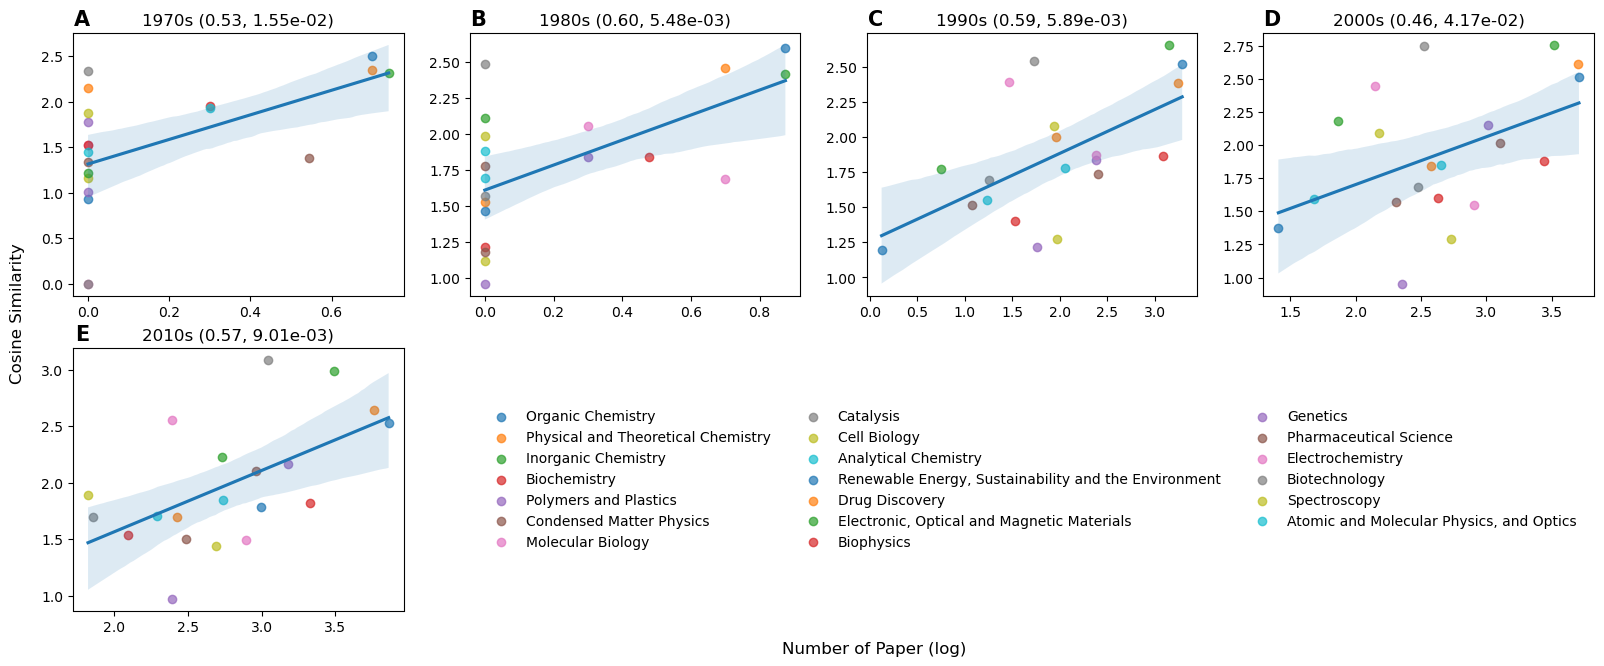

In [15]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

# 用 0 填充缺失值
count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

# 获取所有年代的列表
decades = count_df.index.tolist()

# 创建一个 2x4 的 GridSpec 布局（2 行 4 列）
fig = plt.figure(figsize=(18, 7))
gs = GridSpec(2, 4, figure=fig, wspace=0.2)

pannel_labels = list("ABCDEFG")
center_venue = 'PNAS'

# 为每个年代创建一个子图
for i, decade in enumerate(decades):

    ax = fig.add_subplot(gs[i // 4, i % 4])
    # 分学科绘制散点图
    for discipline in disciplines:
        x = np.log10(count_df.loc[decade, discipline]+1) # 添加一个小的偏移量避免log(0)
        y = cs_df.loc[decade, discipline]
        ax.scatter(x, y, label=discipline, alpha=0.7)

    # 创建该年份的 count 和 similarity 数据
    x_vals = np.log10(count_df.loc[decade]+1) # 添加一个小的偏移量避免log(0)
    y_vals = cs_df.loc[decade]
    # 绘制回归线
    sns.regplot(x=x_vals, y=y_vals, ax=ax, scatter=False)
    # 计算皮尔逊相关系数
    corr_coef, p_value = pearsonr(x_vals, y_vals)
    # 设置子图标题，包含相关系数
    ax.set_title(f'{decade} ({corr_coef:.2f}, {p_value:.2e})')
    # 隐藏子图的 xlabel 和 ylabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot pannel labels
    ax.text(0.05, 1.09, pannel_labels[i], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 在第8幅子图的位置生成图例
legend_ax = fig.add_subplot(gs[-2])
legend_ax.axis('off')  # 隐藏坐标轴
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, labels, loc='center', ncol=3, frameon=False)

fig.supxlabel('Number of Paper (log)')
fig.supylabel('Cosine Similarity')

fig.subplots_adjust(left=0.055, right=0.9, top=0.9, bottom=0.075, wspace=0.1, hspace=0.2)

plt.show()

In [16]:
fig.savefig('JACS_correlation.pdf', 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

## Archive (JACS)

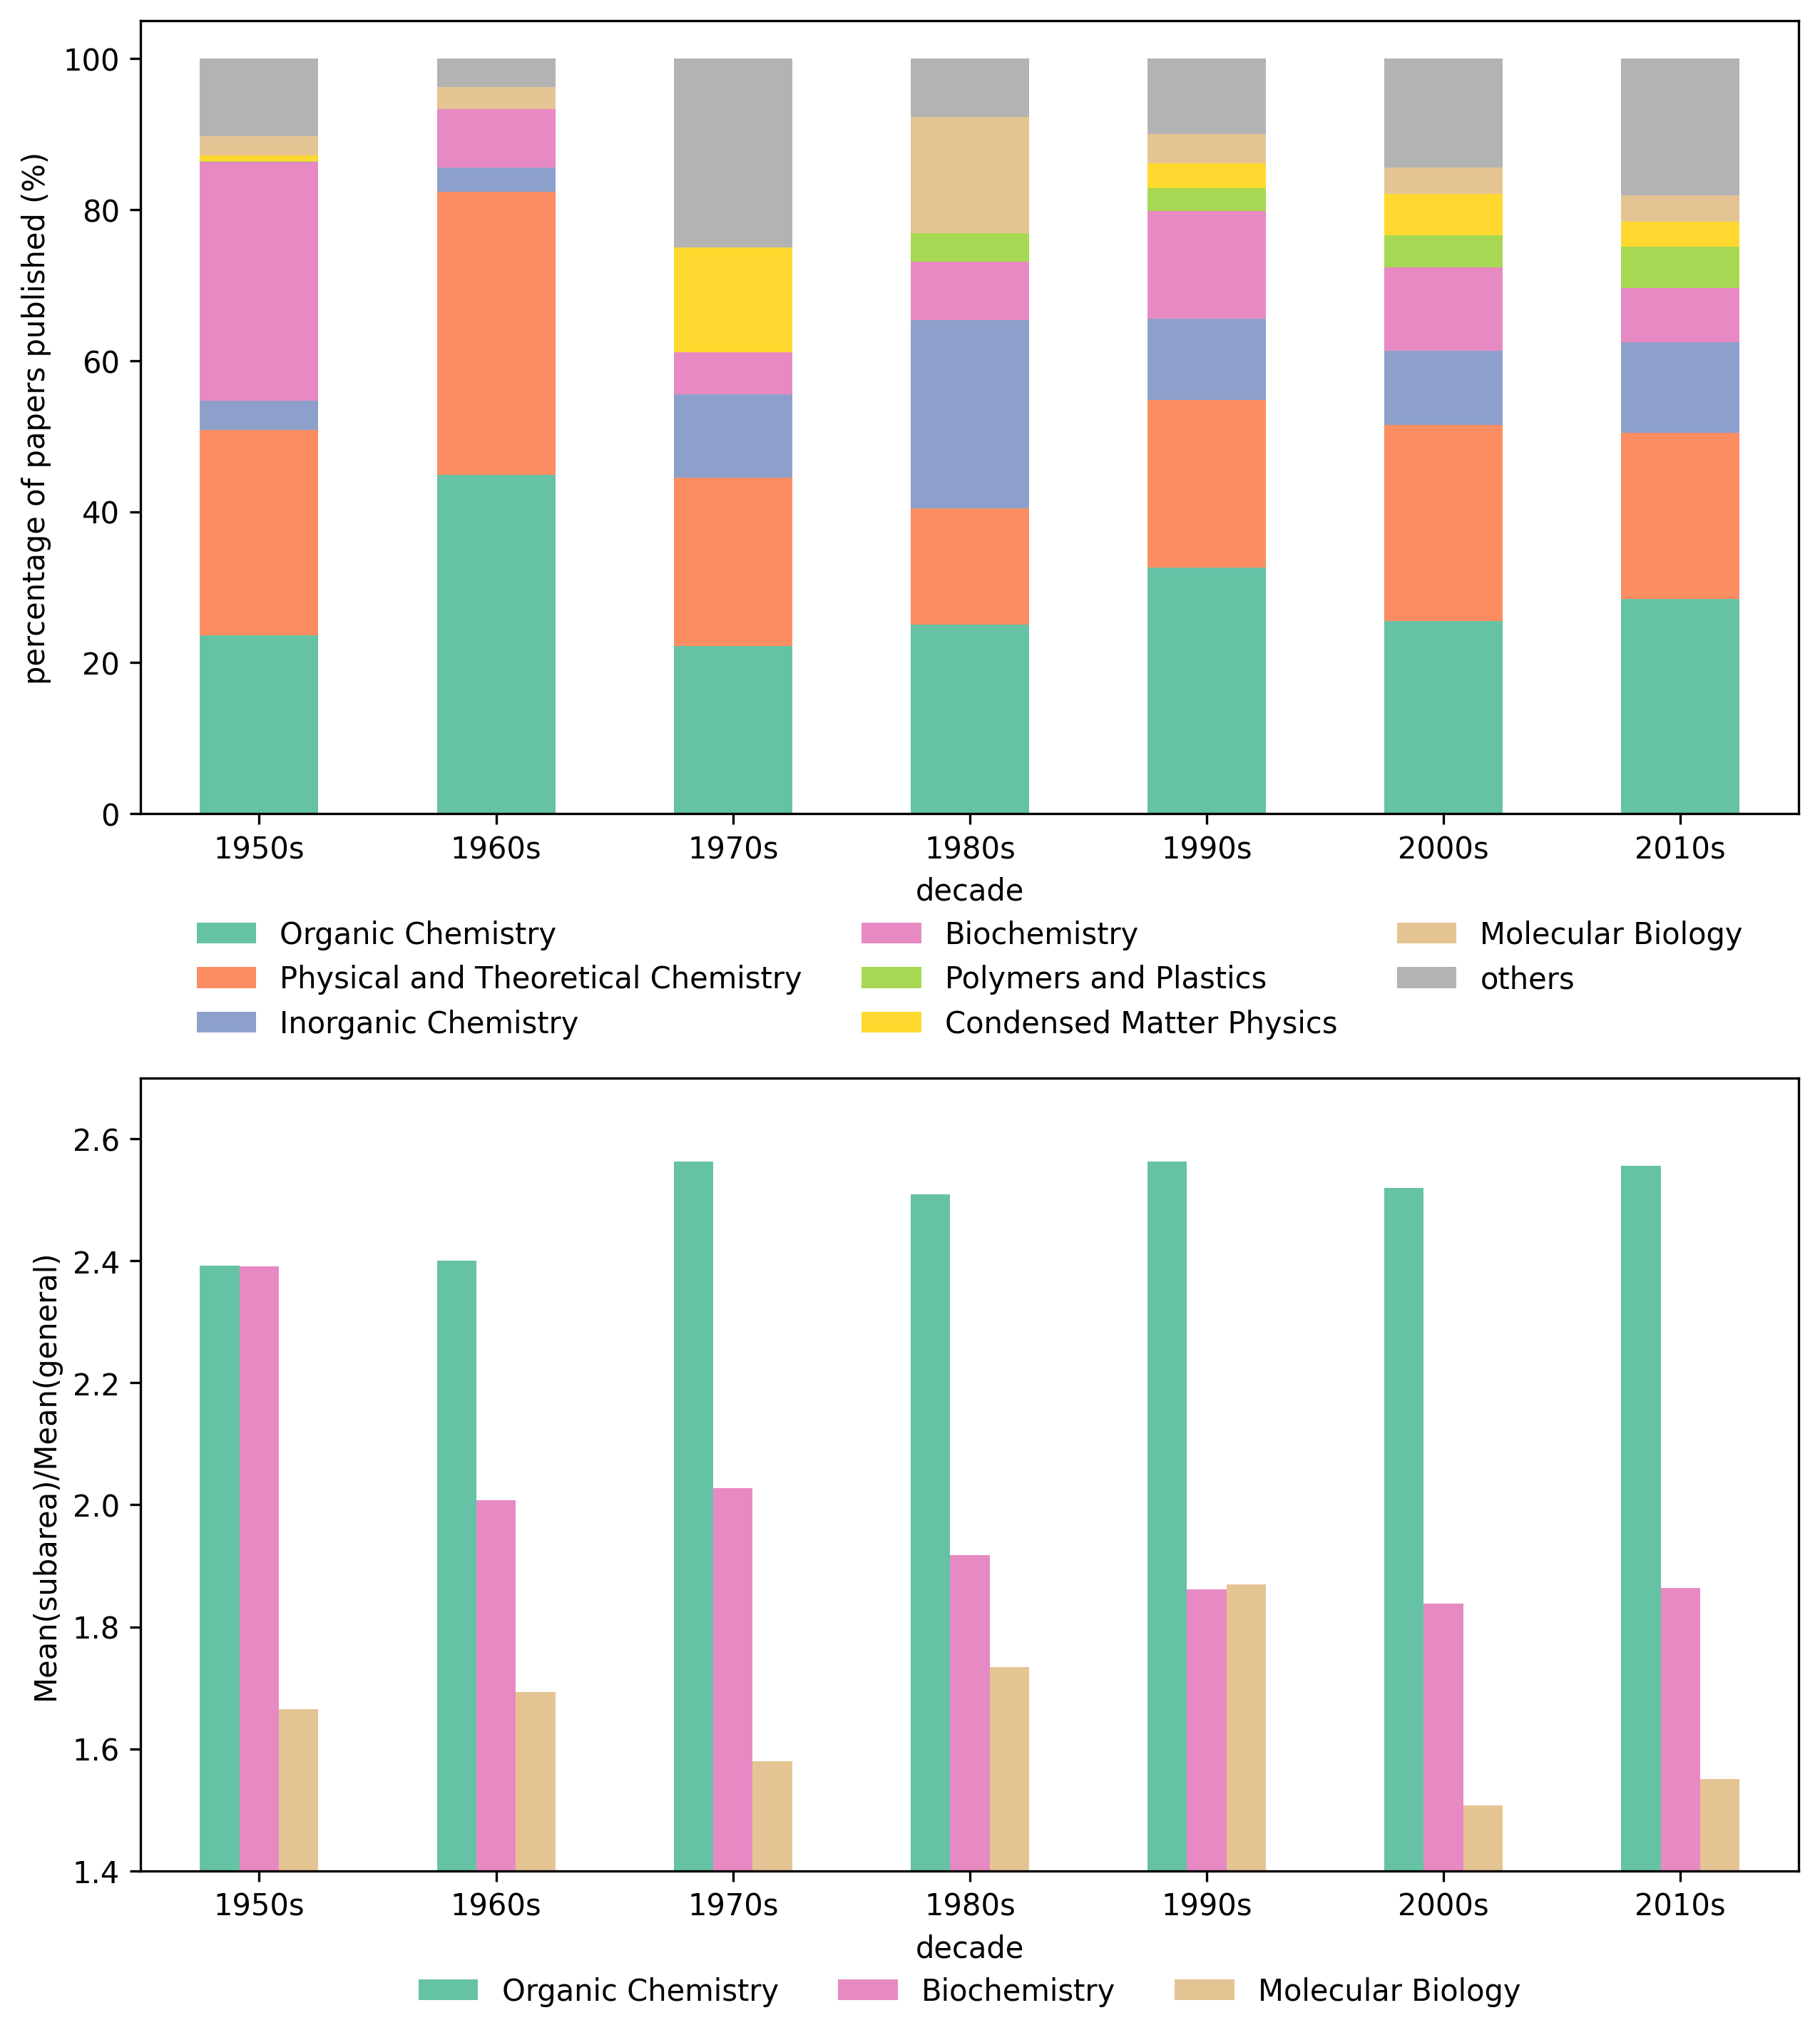

In [251]:
color_dict = {'Organic Chemistry': '#66c2a5',
              'Physical and Theoretical Chemistry': '#fc8d62',
              'Inorganic Chemistry': '#8da0cb',	
              'Biochemistry': '#e78ac3',
              'Polymers and Plastics': '#a6d854',
              'Condensed Matter Physics': '#ffd92f',
              'Molecular Biology': '#e5c494',
              'others': '#b3b3b3'}

fig = plt.figure(figsize=(10,12), dpi=300)

plt.subplot(2,1,1)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(2,1,2)
ax_cs = cs_df[['Organic Chemistry',
               'Biochemistry', 
               'Molecular Biology']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(1.4, 2.7)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [252]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/JACS.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

## PRL

In [17]:
count_df = count_paper_num_for_subarea(24807848, collapse_into_others=20)

2024-08-18 14:47:42 -- start searching in 1970 to 1979
2024-08-18 14:47:42 -- start loading 'paper_df'...
2024-08-18 14:47:42 -- finish.
2024-08-18 14:47:42 -- start loading 'ref_df'...
2024-08-18 14:47:43 -- finish.
2024-08-18 14:47:43 -- start loading VID_labeled...
2024-08-18 14:47:43 -- finish.
2024-08-18 14:47:44 -- start searching in 1980 to 1989
2024-08-18 14:47:44 -- start loading 'paper_df'...
2024-08-18 14:47:44 -- finish.
2024-08-18 14:47:44 -- start loading 'ref_df'...
2024-08-18 14:47:45 -- finish.
2024-08-18 14:47:45 -- start loading VID_labeled...
2024-08-18 14:47:45 -- finish.
2024-08-18 14:47:48 -- start searching in 1990 to 1999
2024-08-18 14:47:48 -- start loading 'paper_df'...
2024-08-18 14:47:49 -- finish.
2024-08-18 14:47:49 -- start loading 'ref_df'...
2024-08-18 14:47:50 -- finish.
2024-08-18 14:47:50 -- start loading VID_labeled...
2024-08-18 14:47:50 -- finish.
2024-08-18 14:47:54 -- start searching in 2000 to 2009
2024-08-18 14:47:54 -- start loading 'paper_d

In [18]:
count_df

decade,Condensed Matter Physics,"Atomic and Molecular Physics, and Optics",Nuclear and High Energy Physics,Statistical and Nonlinear Physics,Physical and Theoretical Chemistry,Astronomy and Astrophysics,Mechanical Engineering,Mathematical Physics,Biophysics,Applied Mathematics,Polymers and Plastics,Instrumentation,Mechanics of Materials,Atmospheric Science,Molecular Biology,Metals and Alloys,Cell Biology,Electrical and Electronic Engineering,Genetics,"Electronic, Optical and Magnetic Materials",others
1970s,167.666667,51.583333,64.000000,2.000000,24.416667,NaN,1.000000,7.500000,1.500000,NaN,0.250000,2.500000,NaN,NaN,NaN,NaN,NaN,7.500000,NaN,NaN,22.333333
1980s,217.083333,95.750000,135.333333,4.250000,42.666667,2.500000,12.250000,13.333333,2.000000,3.000000,1.500000,2.833333,2.500,NaN,1.000000,NaN,NaN,3.500000,NaN,2.000000,28.833333
1990s,346.333333,200.916667,317.166667,136.500000,77.500000,14.583333,46.416667,35.416667,22.166667,34.166667,8.583333,4.666667,1.250,2.000000,6.416667,1.000000,6.666667,5.833333,3.000000,4.000000,125.833333
2000s,3451.709524,1759.292857,934.833333,992.042857,587.342857,195.500000,117.616667,168.916667,138.069048,102.350000,91.316667,67.185714,41.700,60.166667,39.952381,33.426190,48.259524,44.166667,36.183333,10.833333,891.326190
2010s,5155.502381,3708.842857,2638.400000,1096.752381,675.475000,458.283333,258.526190,149.525000,70.119048,85.366667,89.809524,107.766667,71.725,48.983333,58.594048,70.458333,48.451190,36.483333,31.976190,49.341667,1025.207143


In [19]:
cs_df = cal_subarea_avg_cs(24807848)

2024-08-18 14:50:41 -- start loading word vectors...
2024-08-18 14:50:41 -- word vectors loaded, and its shape is: (5686, 100)
2024-08-18 14:50:41 -- start loading VID_labeled...
2024-08-18 14:50:41 -- finish.
2024-08-18 14:50:43 -- start loading word vectors...
2024-08-18 14:50:43 -- word vectors loaded, and its shape is: (9337, 100)
2024-08-18 14:50:43 -- start loading VID_labeled...
2024-08-18 14:50:43 -- finish.
2024-08-18 14:50:46 -- start loading word vectors...
2024-08-18 14:50:46 -- word vectors loaded, and its shape is: (15019, 100)
2024-08-18 14:50:46 -- start loading VID_labeled...
2024-08-18 14:50:46 -- finish.
2024-08-18 14:50:49 -- start loading word vectors...
2024-08-18 14:50:49 -- word vectors loaded, and its shape is: (27460, 100)
2024-08-18 14:50:49 -- start loading VID_labeled...
2024-08-18 14:50:49 -- finish.
2024-08-18 14:50:53 -- start loading word vectors...
2024-08-18 14:50:53 -- word vectors loaded, and its shape is: (37594, 100)
2024-08-18 14:50:53 -- start l

In [20]:
cs_df

decade,Statistical and Nonlinear Physics,General Physics and Astronomy,Mathematical Physics,Physics and Astronomy (miscellaneous),Nuclear and High Energy Physics,Condensed Matter Physics,"Atomic and Molecular Physics, and Optics","Electronic, Optical and Magnetic Materials",Astronomy and Astrophysics,Physical and Theoretical Chemistry,Space and Planetary Science,General Mathematics,Geometry and Topology,Analysis,General Materials Science,Mechanics of Materials,Ceramics and Composites,Nuclear Energy and Engineering,Metals and Alloys,Algebra and Number Theory,Mathematics (miscellaneous),Applied Mathematics,Materials Chemistry,Geophysics,Instrumentation,Computational Mathematics,Electrical and Electronic Engineering,Fluid Flow and Transfer Processes,Control and Optimization,Catalysis,"Surfaces, Coatings and Films",Discrete Mathematics and Combinatorics,Mechanical Engineering,Geochemistry and Petrology,General Engineering,Signal Processing,Inorganic Chemistry,Aerospace Engineering,Polymers and Plastics,Colloid and Surface Chemistry,Theoretical Computer Science,Computational Theory and Mathematics,General Chemistry,Logic,Atmospheric Science,Electrochemistry,"Renewable Energy, Sustainability and the Environment",Energy Engineering and Power Technology,Earth and Planetary Sciences (miscellaneous),Computer Networks and Communications,General Chemical Engineering,Numerical Analysis,Chiropractics,General Computer Science,Spectroscopy,Geology,Control and Systems Engineering,Surfaces and Interfaces,Fuel Technology,Acoustics and Ultrasonics,Finance,Software,Ocean Engineering,Computer Graphics and Computer-Aided Design,Oceanography,General Earth and Planetary Sciences,Philosophy,Geotechnical Engineering and Engineering Geology,Artificial Intelligence,Biophysics,Civil and Structural Engineering,History and Philosophy of Science,Earth-Surface Processes,General Energy,Hardware and Architecture,Computer Science Applications,Radiation,Literature and Literary Theory,Language and Linguistics,Music,Information Systems,Industrial and Manufacturing Engineering,Filtration and Separation,Religious Studies,Linguistics and Language,Automotive Engineering,General Arts and Humanities,Soil Science,History,Visual Arts and Performing Arts,Psychology (miscellaneous),Computers in Earth Sciences,Water Science and Technology,Cultural Studies,Modeling and Simulation,Management Science and Operations Research,Archeology (arts and humanities),Statistics and Probability,Structural Biology,"Economics, Econometrics and Finance (miscellaneous)","General Economics, Econometrics and Finance",Accounting,Economics and Econometrics,Archeology,Paleontology,Political Science and International Relations,Environmental Chemistry,Ecological Modeling,Classics,"Business, Management and Accounting (miscellaneous)",Organic Chemistry,Conservation,"Safety, Risk, Reliability and Quality",Multidisciplinary,Library and Information Sciences,Strategy and Management,Sociology and Political Science,Experimental and Cognitive Psychology,Arts and Humanities (miscellaneous),Cognitive Neuroscience,Education,Global and Planetary Change,Analytical Chemistry,Communication,"Statistics, Probability and Uncertainty",Neuroscience (miscellaneous),Agricultural and Biological Sciences (miscellaneous),Environmental Engineering,Organizational Behavior and Human Resource Management,Transportation,Industrial Relations,Business and International Management,General Social Sciences,Public Administration,Computer Vision and Pattern Recognition,"General Business, Management and Accounting",Ecology,Process Chemistry and Technology,Media Technology,Nature and Landscape Conservation,Sensory Systems,Building and Construction,Social Sciences (miscellaneous),"Geography, Planning and Development",Gender Studies,"Ecology, Evolution, Behavior and Systematics",Management of Technology and Innovation,Insect Science,Biomaterials,Horticulture,Molecular Biology,Social Psychology,Architecture,Forestry,Law,Clinical Psychology,Plant

In [23]:
disciplines = ['Condensed Matter Physics',
 'Atomic and Molecular Physics, and Optics',
 'Nuclear and High Energy Physics',
 'Statistical and Nonlinear Physics',
 'Physical and Theoretical Chemistry',
 'Astronomy and Astrophysics',
 'Mechanical Engineering',
 'Mathematical Physics',
 'Biophysics',
 'Applied Mathematics',
 'Polymers and Plastics',
 'Instrumentation',
 'Mechanics of Materials',
 'Atmospheric Science',
 'Molecular Biology',
 'Metals and Alloys',
 'Cell Biology',
 'Electrical and Electronic Engineering',
 'Genetics',
 'Electronic, Optical and Magnetic Materials',]

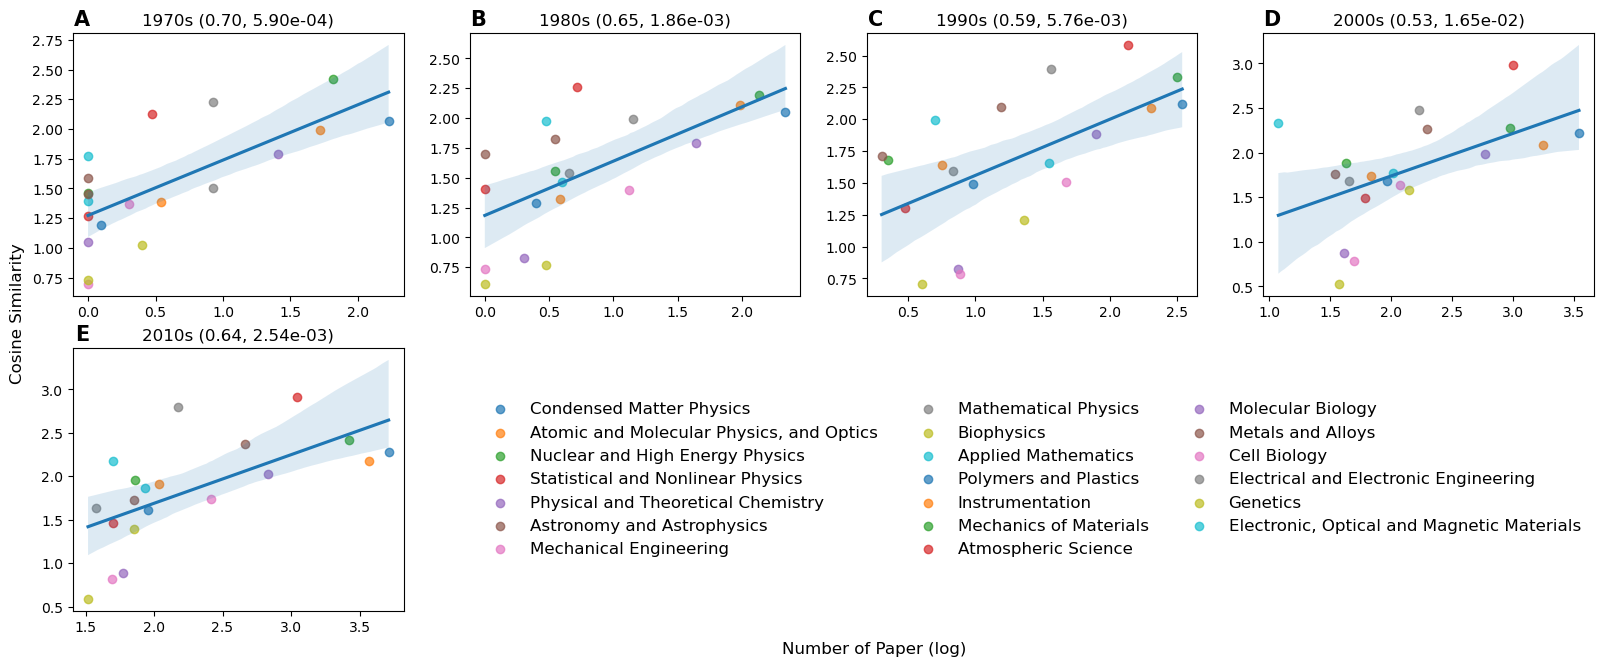

In [28]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

# 用 0 填充缺失值
count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

# 获取所有年代的列表
decades = count_df.index.tolist()

# 创建一个 2x4 的 GridSpec 布局（2 行 4 列）
fig = plt.figure(figsize=(18, 7))
gs = GridSpec(2, 4, figure=fig, wspace=0.2)

pannel_labels = list("ABCDEFG")
center_venue = 'PNAS'

# 为每个年代创建一个子图
for i, decade in enumerate(decades):

    ax = fig.add_subplot(gs[i // 4, i % 4])
    # 分学科绘制散点图
    for discipline in disciplines:
        x = np.log10(count_df.loc[decade, discipline]+1) # 添加一个小的偏移量避免log(0)
        y = cs_df.loc[decade, discipline]
        ax.scatter(x, y, label=discipline, alpha=0.7)

    # 创建该年份的 count 和 similarity 数据
    x_vals = np.log10(count_df.loc[decade]+1) # 添加一个小的偏移量避免log(0)
    y_vals = cs_df.loc[decade]
    # 绘制回归线
    sns.regplot(x=x_vals, y=y_vals, ax=ax, scatter=False)
    # 计算皮尔逊相关系数
    corr_coef, p_value = pearsonr(x_vals, y_vals)
    # 设置子图标题，包含相关系数
    ax.set_title(f'{decade} ({corr_coef:.2f}, {p_value:.2e})')
    # 隐藏子图的 xlabel 和 ylabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot pannel labels
    ax.text(0.05, 1.09, pannel_labels[i], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 在第8幅子图的位置生成图例
legend_ax = fig.add_subplot(gs[-2])
legend_ax.axis('off')  # 隐藏坐标轴
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, labels, loc='center', ncol=3, prop={'size': 12}, frameon=False)

fig.supxlabel('Number of Paper (log)')
fig.supylabel('Cosine Similarity')

fig.subplots_adjust(left=0.055, right=0.9, top=0.9, bottom=0.075, wspace=0.1, hspace=0.2)

plt.show()

In [29]:
fig.savefig('PRL_correlation.pdf', 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

## Archive (PRL)

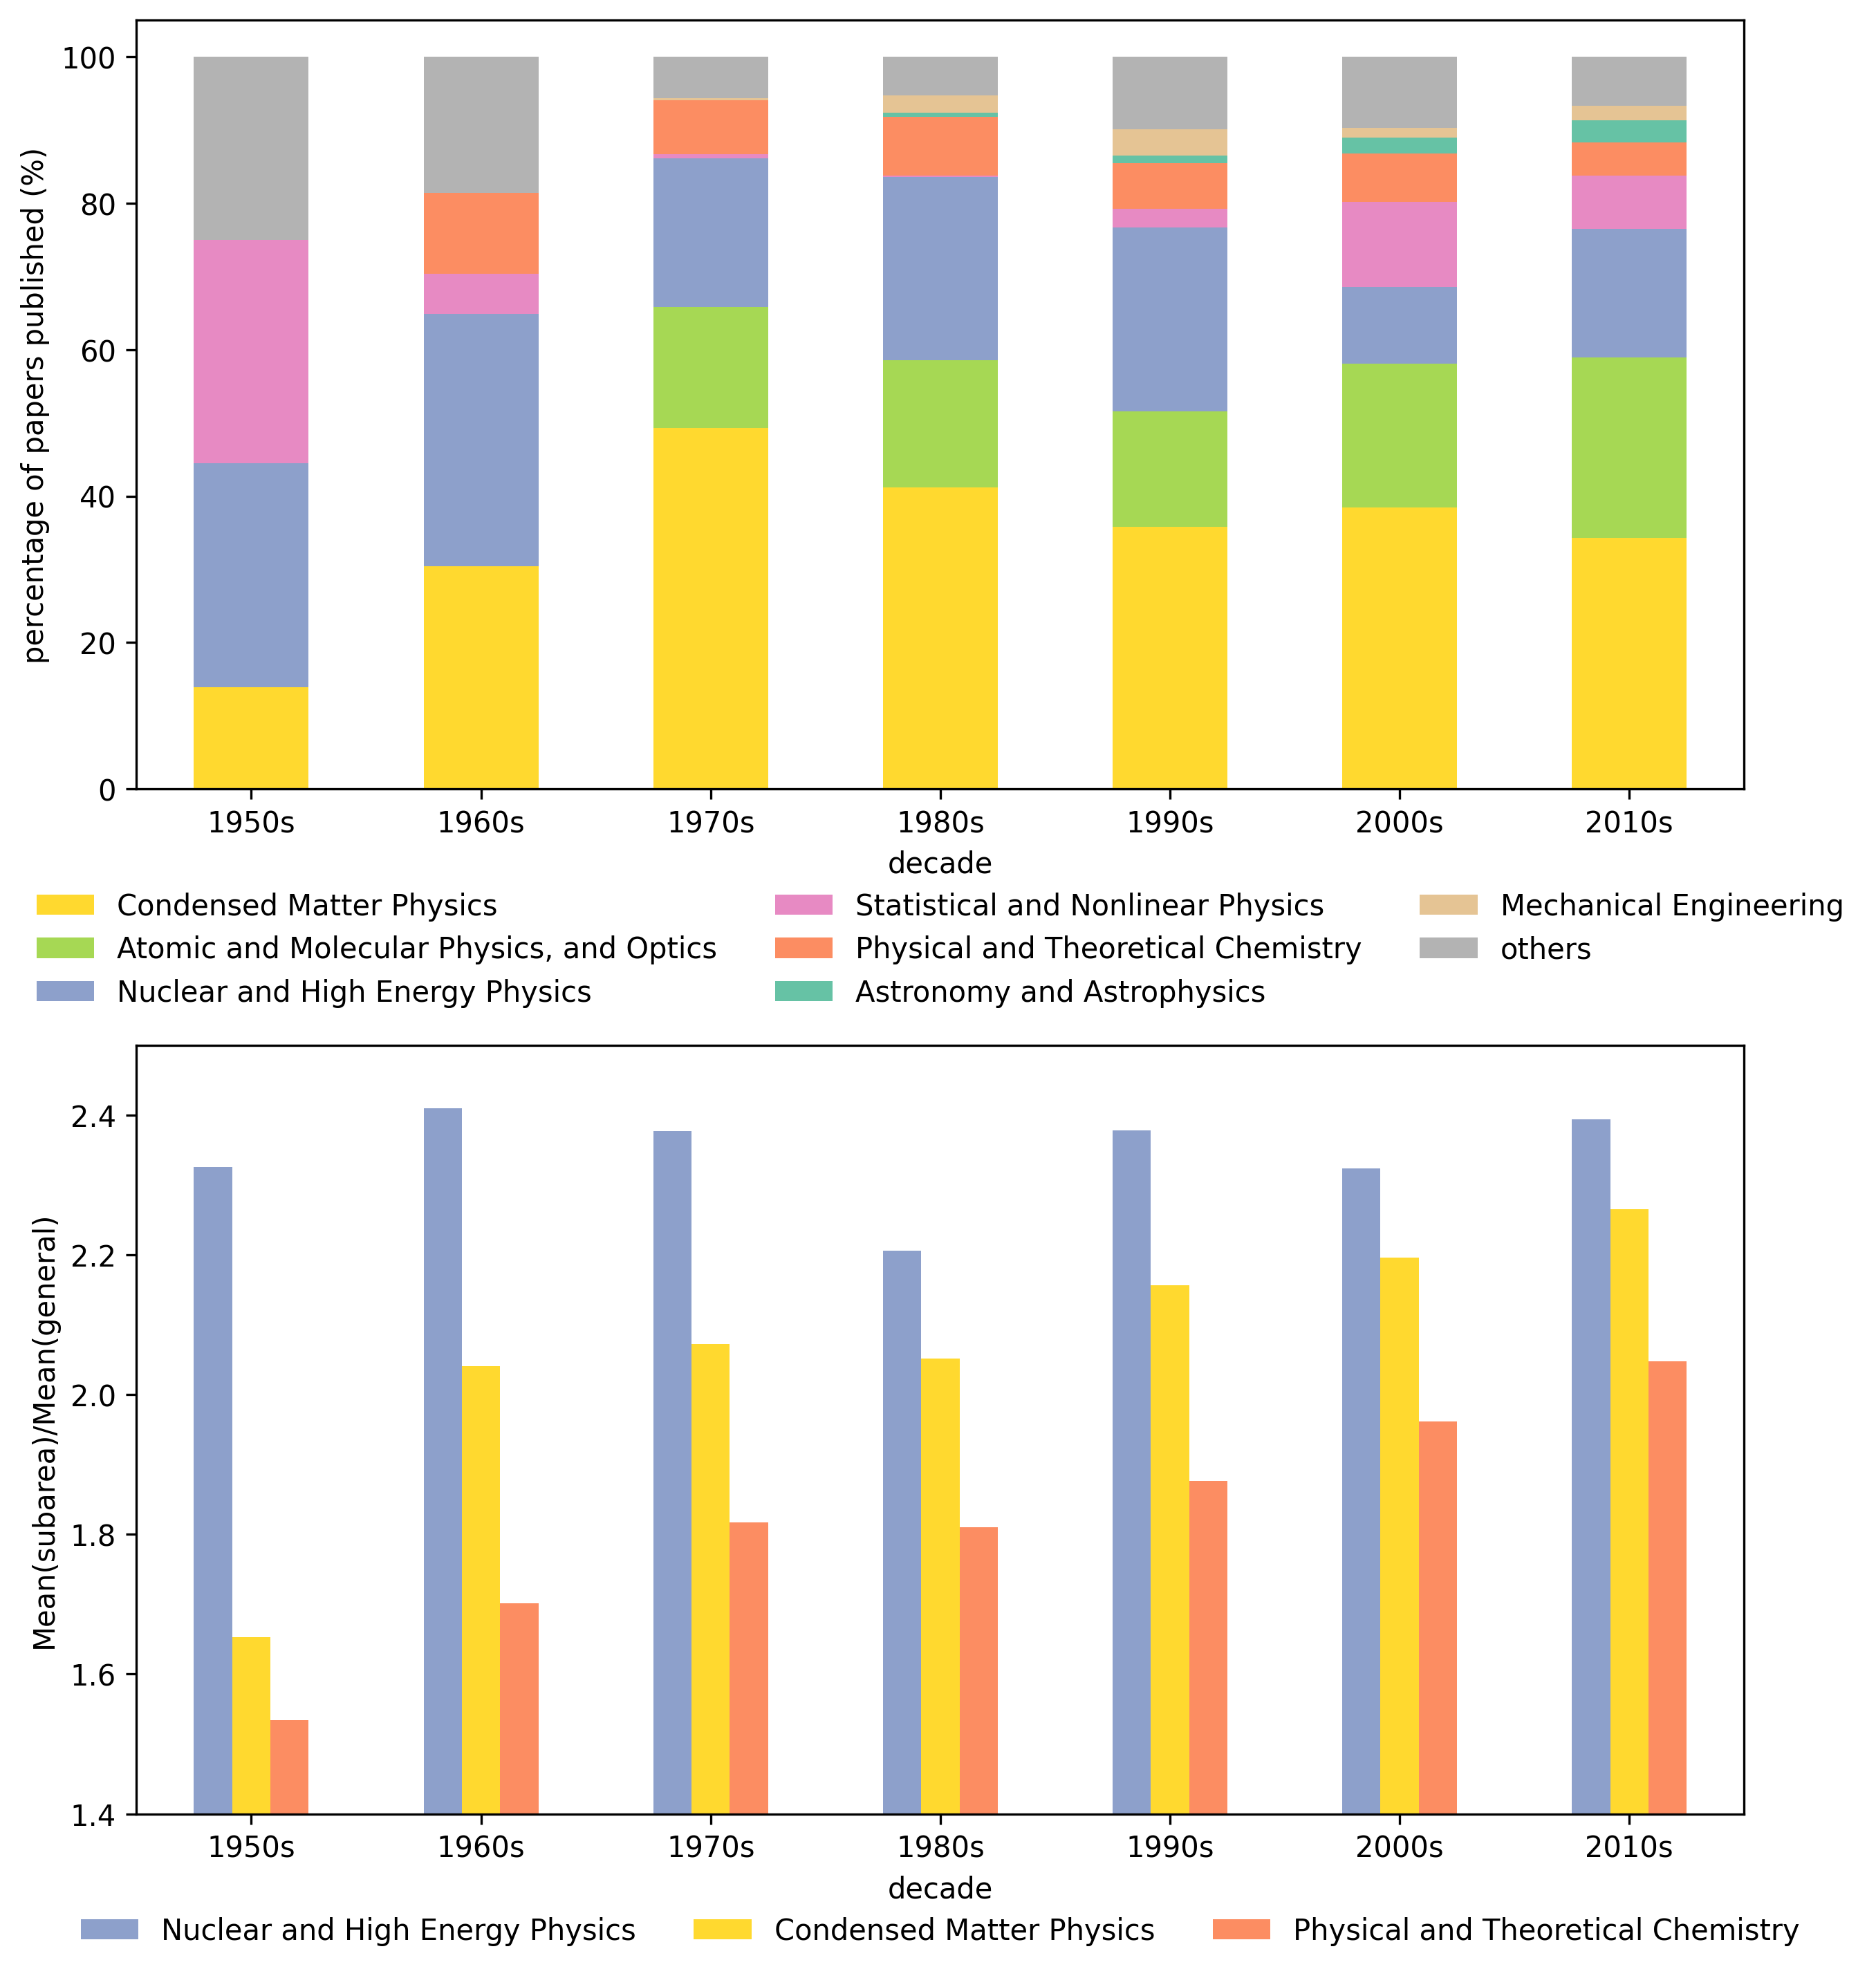

In [285]:
color_dict = {'Condensed Matter Physics': '#ffd92f',
              'Atomic and Molecular Physics, and Optics': '#a6d854',
              'Nuclear and High Energy Physics': '#8da0cb',	
              'Statistical and Nonlinear Physics':  '#e78ac3',
              'Physical and Theoretical Chemistry': '#fc8d62',	
              'Astronomy and Astrophysics': '#66c2a5',	
              'Mechanical Engineering': '#e5c494',
              'others': '#b3b3b3'
              }

fig = plt.figure(figsize=(10,12), dpi=300)

plt.subplot(2,1,1)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(2,1,2)
ax_cs = cs_df[['Nuclear and High Energy Physics',
               'Condensed Matter Physics', 
               'Physical and Theoretical Chemistry']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(1.4, 2.5)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [286]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/PRL.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')